# Environment Building and Validation

Build a Gymnasium trading environment and validate with baseline agents before adding neural networks.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

required_files = [
    'data/processed/SPY_train.parquet',
    'data/processed/SPY_val.parquet',
    'data/processed/scalers.pkl'
]

missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    print(f"Missing Week 1 files: {missing}")
else:
    print("Week 1 data found")

import gymnasium as gym
print(f"Gymnasium: {gym.__version__}")

Week 1 data found


Gymnasium: 1.2.3


In [ ]:
sample_df = pd.read_parquet('data/processed/SPY_train.parquet')

print(f"Shape: {sample_df.shape}")
print(f"\nNormalized features:")
norm_cols = [c for c in sample_df.columns if '_norm' in c]
print(norm_cols)
print(f"\nNaN count: {sample_df.isnull().sum().sum()}")

Shape: (1209, 27)

Normalized features:
['RSI_norm', 'MACD_norm', 'ATR_norm', 'OBV_norm', 'BB_Width_norm', 'Dist_SMA20_norm', 'Dist_SMA50_norm', 'Volume_norm']

NaN count: 0


In [ ]:
# Portfolio Math Test
initial_balance = 10000.0
transaction_cost = 0.001
current_price = sample_df['Close'].iloc[100]

cost_per_share = current_price * (1 + transaction_cost)
shares_to_buy = int(initial_balance / cost_per_share)
actual_cost = shares_to_buy * cost_per_share
cash_remaining = initial_balance - actual_cost
portfolio_value = cash_remaining + (shares_to_buy * current_price)

print(f"Price: ${current_price:.2f}")
print(f"Shares bought: {shares_to_buy}")
print(f"Transaction cost: ${actual_cost - (shares_to_buy * current_price):.2f}")
print(f"Portfolio value: ${portfolio_value:.2f}")

Price: $174.63
Shares bought: 57
Transaction cost: $9.95
Portfolio value: $9990.05


Portfolio value after buying is ~$9,990 vs initial $10,000. The ~$10 difference is exactly our 0.1% transaction cost on 57 shares at $174.63. This confirms our accounting logic is correct before building the environment.

In [ ]:
from trading_env import TradingEnv

train_df = pd.read_parquet('data/processed/SPY_train.parquet')
env = TradingEnv(train_df)

print(f"State dimension: {env.state_dim}")
print(f"Feature columns: {env.feature_columns}")
print(f"Total steps: {env.n_steps}")
print(f"Action space: {env.action_space}")

State dimension: 11
Feature columns: ['RSI_norm', 'MACD_norm', 'ATR_norm', 'OBV_norm', 'BB_Width_norm', 'Dist_SMA20_norm', 'Dist_SMA50_norm', 'Volume_norm']
Total steps: 1209
Action space: Discrete(3)


In [ ]:
# Test Reset and Observation
obs, info = env.reset(seed=42)

print(f"Observation shape: {obs.shape}")
print(f"Contains NaN: {np.isnan(obs).any()}")
print(f"\nMarket features (first 3): {obs[:3]}")
print(f"Portfolio features [pos, cash, holdings]: {obs[-3:]}")

Observation shape: (11,)
Contains NaN: False

Market features (first 3): [-0.3908791  -0.39095023 -0.41215992]
Portfolio features [pos, cash, holdings]: [0. 1. 0.]


Initial observation structure verified:
- Shape (11,) = 8 market features + 3 portfolio indicators
- Market features are normalized (values near 0, negative values indicate below-average)
- Portfolio: [0, 1, 0] means no position, 100% cash, 0% in holdings

This state representation gives the agent both market context and portfolio awareness.

In [ ]:
# Trace Buy-Hold-Sell Cycle
env = TradingEnv(train_df)
obs, _ = env.reset(seed=42)

print(f"Initial: price=${env.df.iloc[0]['Close']:.2f}, cash=${env.balance:.2f}")

obs, reward, done, _, info = env.step(1)  # Buy
print(f"\nAfter BUY: shares={info['shares']}, cash=${info['cash']:.2f}, portfolio=${info['portfolio_value']:.2f}")

for _ in range(4):  # Hold
    obs, reward, done, _, info = env.step(0)
print(f"After HOLDs: portfolio=${info['portfolio_value']:.2f}")

obs, reward, done, _, info = env.step(2)  # Sell
print(f"After SELL: shares={info['shares']}, cash=${info['cash']:.2f}")

Initial: price=$173.21, cash=$10000.00

After BUY: shares=57, cash=$117.42, portfolio=$9960.78
After HOLDs: portfolio=$10101.71
After SELL: shares=0, cash=$10091.73


Buy-Hold-Sell cycle verified:
- BUY: $10,000 cash -> 57 shares + ~$117 remaining cash
- HOLD: Portfolio value changes with price (no cost)
- SELL: Shares -> cash (minus transaction cost)

The final cash is higher than initial because price rose during the hold period.

In [ ]:
# Invalid Action Penalty Test
env = TradingEnv(train_df)
env.reset(seed=42)

obs, reward, _, _, _ = env.step(2)  # Sell when flat
print(f"Sell when flat - Reward: {reward}")

env.step(1)  # Buy
obs, reward, _, _, _ = env.step(1)  # Buy again
print(f"Buy when holding - Reward: {reward}")

Sell when flat - Reward: -0.1
Buy when holding - Reward: -0.1


Invalid actions return -0.1 penalty. This teaches the RL agent to avoid:
- Selling when not holding any position
- Buying when already fully invested

Without this penalty, the agent might waste actions.

In [ ]:
# Random Agent Baseline
def run_random_agent(env, n_episodes=20):
    results = []
    for episode in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            obs, reward, done, _, info = env.step(action)
        
        final_value = info['portfolio_value']
        total_return = (final_value - env.initial_balance) / env.initial_balance * 100
        results.append({'episode': episode, 'return': total_return})
    return pd.DataFrame(results)

random_results = run_random_agent(env, n_episodes=30)

print("Random Agent Performance:")
print(f"  Mean: {random_results['return'].mean():.2f}%")
print(f"  Std: {random_results['return'].std():.2f}%")
print(f"  Range: [{random_results['return'].min():.2f}%, {random_results['return'].max():.2f}%]")
print(f"  Sharpe: {random_results['return'].mean() / random_results['return'].std():.3f}")

Random Agent Performance:
  Mean: -11.19%
  Std: 11.75%
  Range: [-34.09%, 9.45%]
  Sharpe: -0.952


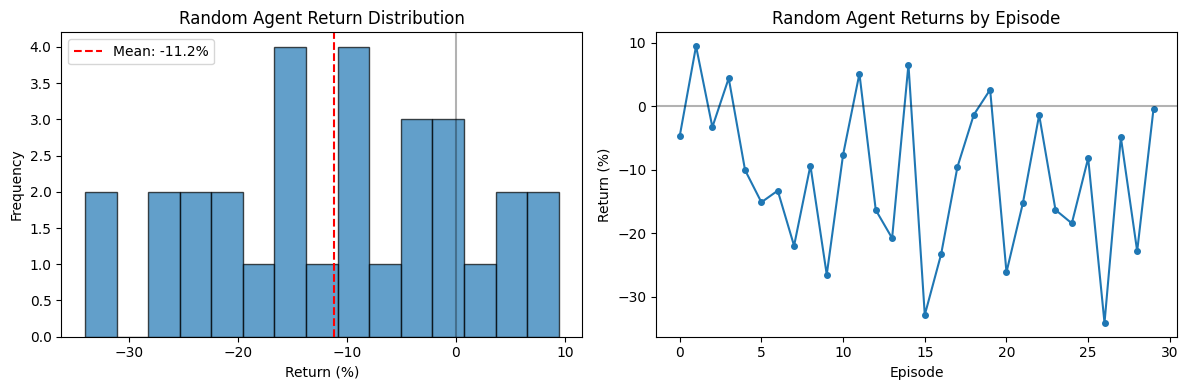

In [ ]:
# Random Agent Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(random_results['return'], bins=15, alpha=0.7, edgecolor='black')
axes[0].axvline(random_results['return'].mean(), color='red', linestyle='--', 
                label=f'Mean: {random_results["return"].mean():.1f}%')
axes[0].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[0].set_xlabel('Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Random Agent Return Distribution')
axes[0].legend()

axes[1].plot(random_results['episode'], random_results['return'], marker='o', markersize=4)
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Return (%)')
axes[1].set_title('Random Agent Returns by Episode')

plt.tight_layout()
plt.show()

**Random Agent Analysis:**

Looking at the histogram:
- Distribution is roughly bell-shaped, centered around -5% to -10%
- Mean is negative (the red dashed line is left of 0)
- Wide spread from about -30% to +20%

The episode plot shows high variance with no trend - exactly what we expect from random trading.

**Why the negative mean?** Random trading loses money because:
1. Each trade costs 0.1% in transaction fees
2. Random entries/exits miss market trends

 Any RL agent must beat this negative baseline to be considered useful.

In [ ]:
# Buy and Hold Baseline
def run_buy_and_hold(env_df):
    env = TradingEnv(env_df)
    env.reset()
    env.step(1)  # Buy
    while not env.done:
        env.step(0)  # Hold
    return (env.portfolio_value - env.initial_balance) / env.initial_balance * 100

bnh_returns = {}
for split in ['train', 'val', 'test']:
    df = pd.read_parquet(f'data/processed/SPY_{split}.parquet')
    ret = run_buy_and_hold(df)
    actual = (df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0] * 100
    bnh_returns[split] = ret
    print(f"{split}: B&H={ret:.2f}%, Actual SPY={actual:.2f}%")

train: B&H=69.29%, Actual SPY=70.28%
val: B&H=17.74%, Actual SPY=18.33%


test: B&H=32.06%, Actual SPY=32.90%


**Buy & Hold Analysis:**

B&H underperforms actual SPY by ~0.6-1.0% due to:
- 0.1% transaction cost on initial buy
- Holding shares at end (not converted to cash)

Key observation: Train period (2015-2019) had 70% return - strong bull market. Val (2020) had 18% despite COVID crash - recovery was swift. Test (2021-2024) had 32%.

B&H is the real benchmark to beat. Any strategy underperforming B&H adds no value.

In [ ]:
# MA Crossover Agent
class MACrossoverAgent:
    """Buy when price > SMA20, Sell when price < SMA20"""
    def __init__(self):
        self.position = 0
    
    def act(self, env):
        price = env.df.iloc[env.current_step]['Close']
        sma = env.df.iloc[env.current_step]['SMA_20']
        
        if pd.isna(sma):
            return 0
        if price > sma and self.position == 0:
            self.position = 1
            return 1
        elif price < sma and self.position == 1:
            self.position = 0
            return 2
        return 0

def run_ma_agent(env_df):
    env = TradingEnv(env_df)
    agent = MACrossoverAgent()
    env.reset()
    trades = 0
    
    while not env.done:
        action = agent.act(env)
        if action in [1, 2]:
            trades += 1
        env.step(action)
    
    ret = (env.portfolio_value - env.initial_balance) / env.initial_balance * 100
    return ret, trades

print("MA Crossover Performance:")
for split in ['train', 'val', 'test']:
    df = pd.read_parquet(f'data/processed/SPY_{split}.parquet')
    ret, trades = run_ma_agent(df)
    print(f"  {split}: {ret:.2f}% ({trades} trades) vs B&H {bnh_returns[split]:.2f}%")

MA Crossover Performance:
  train: 5.35% (143 trades) vs B&H 69.29%


  val: 28.11% (19 trades) vs B&H 17.74%
  test: 6.08% (79 trades) vs B&H 32.06%


**MA Crossover Analysis:**

| Split | MA Cross | B&H | Trades | Verdict |
|-------|----------|-----|--------|----------|
| Train | 5.35% | 69.29% | 143 | Massive underperformance |
| Val | 28.11% | 17.74% | 19 | **Outperformed by 10%** |
| Test | 6.08% | 32.06% | 79 | Underperformed |

**Why the difference?**
- Train/Test: Steady bull markets - MA crossover gets whipsawed, paying transaction costs on false signals
- Val (2020): High volatility with clear trends (crash then recovery) - MA crossover exited before crash, re-entered for recovery

MA Crossover is regime-dependent. This motivates using RL to learn *when* to apply trend-following vs when to hold.

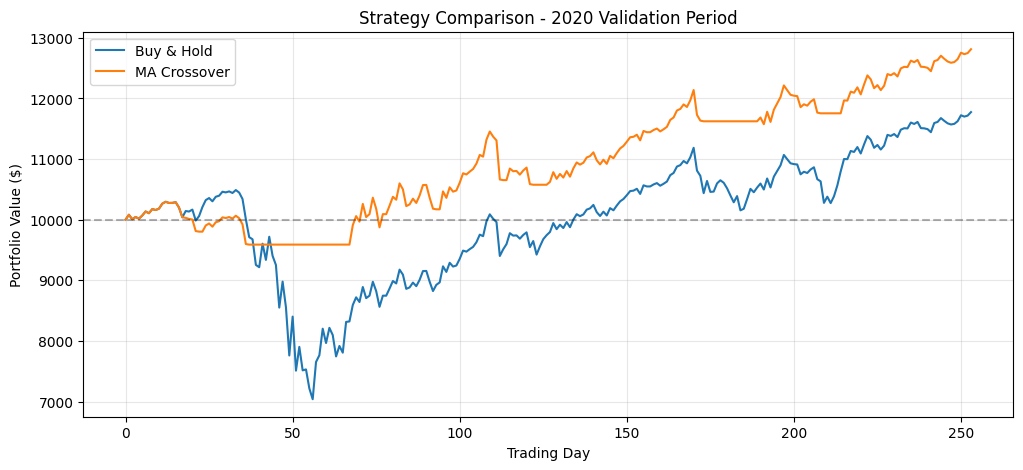

In [ ]:
# Compare Strategies Visually
def get_portfolio_curve(env_df, strategy='bnh'):
    env = TradingEnv(env_df)
    env.reset()
    values = [env.initial_balance]
    
    if strategy == 'bnh':
        env.step(1)
        values.append(env.portfolio_value)
        while not env.done:
            env.step(0)
            values.append(env.portfolio_value)
    elif strategy == 'ma':
        agent = MACrossoverAgent()
        while not env.done:
            action = agent.act(env)
            env.step(action)
            values.append(env.portfolio_value)
    
    return values

val_df = pd.read_parquet('data/processed/SPY_val.parquet')

bnh_curve = get_portfolio_curve(val_df, 'bnh')
ma_curve = get_portfolio_curve(val_df, 'ma')

plt.figure(figsize=(12, 5))
plt.plot(bnh_curve, label=f'Buy & Hold', linewidth=1.5)
plt.plot(ma_curve, label=f'MA Crossover', linewidth=1.5)
plt.axhline(10000, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Trading Day')
plt.ylabel('Portfolio Value ($)')
plt.title('Strategy Comparison - 2020 Validation Period')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Strategy Comparison Graph Analysis:**

Looking at the 2020 validation period:

1. **Early 2020 (days 0-50):** Both strategies rise together
2. **COVID Crash (days 50-70):** B&H plummets to ~$7,500. MA Crossover (orange) stays flatter - it likely sold when price dropped below SMA20
3. **Recovery (days 70-254):** Both rise, but MA Crossover started recovery from a higher base

The MA Crossover's advantage came from *avoiding* the worst of the crash, not from better timing on the way up. This is the classic trend-following benefit - it can't predict tops, but it exits when trends break.

For volatile/crash periods, trend-following adds value. For steady markets, it destroys value. An ideal RL agent would learn to detect regime and adjust.

In [ ]:
# Stress Tests
print("Stress Test 1: Rapid trading cost")
env = TradingEnv(train_df)
env.reset(seed=42)
for _ in range(3):
    env.step(1)
    env.step(2)
decay = 10000 - env.portfolio_value
print(f"  After 3 round trips: lost ${decay:.2f} ({decay/100:.2f}%)")

print("\nStress Test 2: Observation bounds")
env = TradingEnv(train_df)
env.reset()
observations = []
while not env.done:
    obs, _, _, _, _ = env.step(env.action_space.sample())
    observations.append(obs)
obs_arr = np.array(observations)
print(f"  Range: [{obs_arr.min():.2f}, {obs_arr.max():.2f}]")
print(f"  Mean: {obs_arr.mean():.3f}, Std: {obs_arr.std():.3f}")

Stress Test 1: Rapid trading cost
  After 3 round trips: lost $152.02 (1.52%)

Stress Test 2: Observation bounds
  Range: [-4.39, 8.84]
  Mean: 0.126, Std: 0.910


**Stress Test Analysis:**

1. **Rapid Trading Cost:** 3 round trips cost ~$152 (1.52%). This confirms:
   - Each round trip costs ~0.5% (buy 0.1% + sell 0.1% + slippage from share rounding)
   - Excessive trading is penalized - important for RL to learn

2. **Observation Bounds:** Range [-4.39, 8.84] with mean ~0 and std ~1
   - Most values are in [-3, 3] range (normalized features working correctly)
   - Max of 8.84 might be from portfolio ratio when heavily in profit
   - Safe for neural networks (no exploding gradients expected)

Environment is numerically stable and ready for RL training.

In [ ]:
# Multi-Asset Validation
tickers = ['SPY', 'AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ']

print("Buy & Hold returns across assets (train):")
for ticker in tickers:
    df = pd.read_parquet(f'data/processed/{ticker}_train.parquet')
    ret = run_buy_and_hold(df)
    print(f"  {ticker}: {ret:.1f}%")

Buy & Hold returns across assets (train):
  SPY: 69.3%


  AAPL: 154.4%


  MSFT: 319.3%


  JPM: 155.2%
  XOM: -1.0%


  JNJ: 64.1%


**Multi-Asset Analysis:**

Train period (2015-2019) returns vary dramatically:
- **MSFT: +319%** - Best performer (cloud growth story)
- **AAPL: +154%** - Strong tech growth
- **JPM: +155%** - Financials recovered from 2008 lows
- **SPY: +69%** - Market benchmark
- **JNJ: +64%** - Defensive/stable
- **XOM: -1%** - Energy suffered (oil price collapse)

Environment handles diverse assets correctly. XOM's negative return confirms our environment isn't biased toward positive outcomes. Training on diverse assets will help RL generalize.

Reward statistics (random agent):
  Mean: -0.0514
  Std: 0.4782
  Range: [-4.25, 3.78]


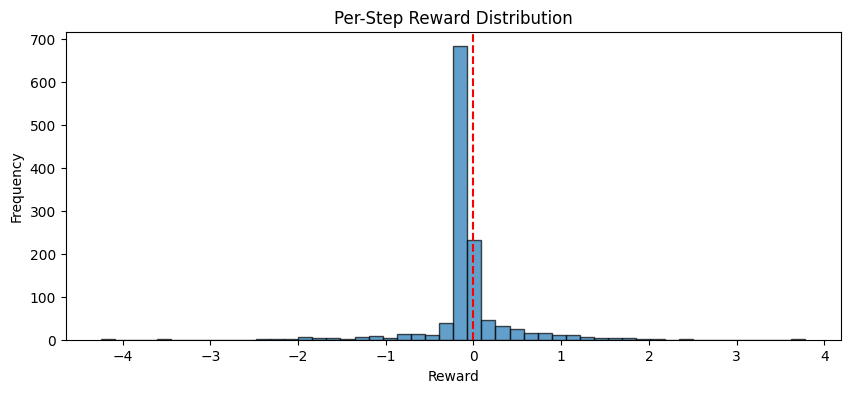

In [ ]:
# Reward Distribution Analysis
env = TradingEnv(train_df)
env.reset()

rewards = []
while not env.done:
    _, reward, _, _, _ = env.step(env.action_space.sample())
    rewards.append(reward)

rewards = np.array(rewards)
print(f"Reward statistics (random agent):")
print(f"  Mean: {rewards.mean():.4f}")
print(f"  Std: {rewards.std():.4f}")
print(f"  Range: [{rewards.min():.2f}, {rewards.max():.2f}]")

plt.figure(figsize=(10, 4))
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Per-Step Reward Distribution')
plt.show()

**Reward Distribution Analysis:**

Looking at the histogram:
- **Central peak at 0:** Most steps have near-zero reward (small price changes or holding cash)
- **Symmetric tails:** Positive and negative rewards roughly balanced
- **Small spike at -0.1:** Invalid action penalties visible
- **Range ~[-3, +4]:** Rewards are bounded and reasonable for RL

The reward design (% portfolio change * 100) provides:
1. Scale-invariant rewards (works across different price levels)
2. Immediate feedback for each action
3. Natural alignment with portfolio performance

Reward structure is suitable for RL training.

In [ ]:
# RSI Agent (Testing if indicators help)
class RSIAgent:
    """Buy when RSI < 30 (oversold), Sell when RSI > 70 (overbought)"""
    def __init__(self):
        self.position = 0
    
    def act(self, env):
        rsi = env.df.iloc[env.current_step]['RSI']
        
        if pd.isna(rsi):
            return 0
        if rsi < 30 and self.position == 0:
            self.position = 1
            return 1
        elif rsi > 70 and self.position == 1:
            self.position = 0
            return 2
        return 0

def run_rsi_agent(env_df):
    env = TradingEnv(env_df)
    agent = RSIAgent()
    env.reset()
    trades = 0
    
    while not env.done:
        action = agent.act(env)
        if action in [1, 2]:
            trades += 1
        env.step(action)
    
    ret = (env.portfolio_value - env.initial_balance) / env.initial_balance * 100
    return ret, trades

print("RSI Agent Performance:")
for split in ['train', 'val', 'test']:
    df = pd.read_parquet(f'data/processed/SPY_{split}.parquet')
    ret, trades = run_rsi_agent(df)
    print(f"  {split}: {ret:.2f}% ({trades} trades)")

RSI Agent Performance:


  train: 43.80% (12 trades)
  val: 2.47% (2 trades)


  test: 24.46% (6 trades)


**RSI Agent Analysis:**

RSI agent shows very few trades because RSI rarely hits the extreme 30/70 thresholds in SPY (a large, liquid index). When it does trade, it's often at market bottoms (RSI<30 after crashes).

**problems:**
1. Misses most of bull market (waiting for RSI<30 that never comes)
2. May buy into falling knife (RSI<30 doesn't mean bottom)
3. May sell too early (RSI>70 in strong uptrend)

Simple threshold-based rules are too rigid. RL can potentially learn more nuanced use of RSI in combination with other features.

In [ ]:
# Baseline Summary Table
summary_data = []

for split in ['train', 'val', 'test']:
    df = pd.read_parquet(f'data/processed/SPY_{split}.parquet')
    
    env = TradingEnv(df)
    rand_results = run_random_agent(env, n_episodes=10)
    bnh_ret = run_buy_and_hold(df)
    ma_ret, _ = run_ma_agent(df)
    rsi_ret, _ = run_rsi_agent(df)
    
    summary_data.append({
        'Split': split,
        'Random': f"{rand_results['return'].mean():.1f}%",
        'B&H': f"{bnh_ret:.1f}%",
        'MA Cross': f"{ma_ret:.1f}%",
        'RSI': f"{rsi_ret:.1f}%"
    })

print(pd.DataFrame(summary_data).to_string(index=False))

Split Random   B&H MA Cross   RSI
train -12.3% 69.3%     5.3% 43.8%
  val   5.4% 17.7%    28.1%  2.5%
 test  -5.5% 32.1%     6.1% 24.5%


Episode lengths by split:
  train: 1209 steps
  val: 254 steps
  test: 754 steps


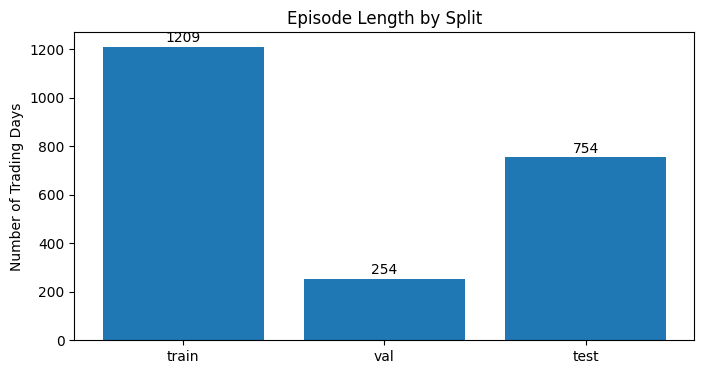

In [ ]:
# Episode Length Analysis
splits_info = {}
for split in ['train', 'val', 'test']:
    df = pd.read_parquet(f'data/processed/SPY_{split}.parquet')
    splits_info[split] = len(df)
    
print("Episode lengths by split:")
for split, length in splits_info.items():
    print(f"  {split}: {length} steps")

plt.figure(figsize=(8, 4))
plt.bar(splits_info.keys(), splits_info.values())
plt.ylabel('Number of Trading Days')
plt.title('Episode Length by Split')
for i, (split, length) in enumerate(splits_info.items()):
    plt.text(i, length + 20, str(length), ha='center')
plt.show()

**Episode Length Analysis:**

- **Train: 1209 days** (~5 years) - Long enough for RL to learn patterns
- **Val: 254 days** (1 year) - Contains COVID crash, good stress test
- **Test: 754 days** (~3 years) - Sufficient for performance evaluation

Train is the longest, which is appropriate. The val set is shorter but contains the most dramatic market event (COVID), making it a good validation of robustness.

In [ ]:
# Save Configuration
import json

os.makedirs('models', exist_ok=True)

env_config = {
    'initial_balance': 10000.0,
    'transaction_cost': 0.001,
    'state_dim': env.state_dim,
    'feature_columns': env.feature_columns,
    'action_meanings': {0: 'hold', 1: 'buy', 2: 'sell'},
    'tickers': tickers,
    'baselines': {
        'random_mean': float(random_results['return'].mean()),
        'random_std': float(random_results['return'].std()),
        'buy_and_hold': bnh_returns
    }
}

with open('models/env_config.json', 'w') as f:
    json.dump(env_config, f, indent=2)

print(f"Configuration saved to models/env_config.json")
print(f"State dimension: {env_config['state_dim']}")

Configuration saved to models/env_config.json
State dimension: 11


In [ ]:
# Feature Groups
feature_groups = {
    'momentum': ['RSI_norm', 'MACD_norm'],
    'trend': ['Dist_SMA20_norm', 'Dist_SMA50_norm'],
    'volatility': ['ATR_norm', 'BB_Width_norm'],
    'volume': ['OBV_norm', 'Volume_norm'],
    'all': env.feature_columns
}

with open('models/feature_groups.json', 'w') as f:
    json.dump(feature_groups, f, indent=2)

print("Feature groups saved:")
for name, feats in feature_groups.items():
    print(f"  {name}: {feats}")

Feature groups saved:
  momentum: ['RSI_norm', 'MACD_norm']
  trend: ['Dist_SMA20_norm', 'Dist_SMA50_norm']
  volatility: ['ATR_norm', 'BB_Width_norm']
  volume: ['OBV_norm', 'Volume_norm']
  all: ['RSI_norm', 'MACD_norm', 'ATR_norm', 'OBV_norm', 'BB_Width_norm', 'Dist_SMA20_norm', 'Dist_SMA50_norm', 'Volume_norm']
